In [2]:
import pandas as pd
import numpy as np
import os

import nibabel as nib

import matplotlib.pyplot as plt
import seaborn as sns

# Metadatas building

In [ ]:
metadatas = []
labels = []

for folder in os.listdir('../data/raw'):
    folder_path = os.path.join('..', 'data', 'raw', folder)
    if not os.path.isdir(folder_path): # skip if not a directory
        continue

    if folder.startswith('labels'):
        label = True
    else:
        label = False
    
    for file in os.listdir(folder_path):
        if file.endswith('.nii.gz'):
            if not label: # if raw image -> build metadatas
                file_path = os.path.join(folder_path, file)
                file_name = "_".join(file.split('.')[0].split('_')[:-1])
                modality = file.split('_')[1]

                img = nib.load(file_path) # Load the image

                shape = list(img.shape)
                spacing = np.array(img.header.get_zooms(), dtype=np.float64) # get x, y, z voxel size
                spacing = np.round(spacing, 2).tolist() # 2 decimals

                FOV = np.prod([shape, spacing], axis=0)
                FOV = np.round(FOV, 2).tolist() # 2 decimals

                # Get intensity statistics
                min_val = np.min(img.get_fdata())
                max_val = np.max(img.get_fdata())
                val_range = np.round([min_val, max_val], 2).tolist()

                # append datas to metadatas
                metadatas.append({'file_name': file_name, 'file_path': file_path, 'modality': modality,
                                'shape(px)': shape, 'spacing(mm)': spacing, 'FOV (mm)': FOV, 'val_range': val_range})

            else: # if label image -> append label path to labels
                file_path = os.path.join(folder_path, file)
                file_name = file.split('.')[0]

                # append label path to labels
                labels.append({'file_name': file_name, 'label_path': file_path})

df = pd.DataFrame(metadatas)
labels_df = pd.DataFrame(labels)

df = pd.merge(df, labels_df, on='file_name', how='left') # merge metadatas with corresponding label paths

display(df.head())

,file_name,file_path,modality,shape(px),spacing(mm),FOV (mm),val_range,mean_val,std_val,median_val,label_path
0,topcow_ct_025,../data/raw/imagesTr_topbrain_ct/topcow_ct_025...,ct,"[271, 340, 206]","[0.49, 0.49, 0.7]","[132.79, 166.6, 144.2]","[-1024.0, 2081.98]",-134.49,657.18,27.01,../data/raw/labelsTr_topbrain_ct/topcow_ct_025...
1,topcow_ct_015,../data/raw/imagesTr_topbrain_ct/topcow_ct_015...,ct,"[316, 390, 203]","[0.43, 0.43, 0.75]","[135.88, 167.7, 152.25]","[-1024.0, 2204.01]",-48.27,671.88,38.01,../data/raw/labelsTr_topbrain_ct/topcow_ct_015...
2,topcow_ct_022,../data/raw/imagesTr_topbrain_ct/topcow_ct_022...,ct,"[287, 351, 224]","[0.49, 0.49, 0.7]","[140.63, 171.99, 156.8]","[-1024.0, 2769.01]",-111.73,582.24,33.02,../data/raw/labelsTr_topbrain_ct/topcow_ct_022...
3,topcow_ct_017,../data/raw/imagesTr_topbrain_ct/topcow_ct_017...,ct,"[319, 430, 527]","[0.44, 0.44, 0.3]","[140.36, 189.2, 158.1]","[-1024.0, 2196.01]",-114.47,638.58,28.01,../data/raw/labelsTr_topbrain_ct/topcow_ct_017...
4,topcow_ct_020,../data/raw/imagesTr_topbrain_ct/topcow_ct_020...,ct,"[290, 387, 200]","[0.46, 0.46, 0.75]","[133.4, 178.02, 150.0]","[-1024.0, 3071.0]",-89.13,667.46,38.01,../data/raw/labelsTr_topbrain_ct/topcow_ct_020...


# Data Visualization

## Voxel spacing distribution depending on modality

/tmp/ipykernel_3530/2781074467.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  voxel_spacing.loc[:, 'x_space'] = voxel_spacing['spacing(mm)'].apply(lambda x: x[0])
/tmp/ipykernel_3530/2781074467.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  voxel_spacing.loc[:, 'y_space'] = voxel_spacing['spacing(mm)'].apply(lambda x: x[1])
/tmp/ipykernel_3530/2781074467.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

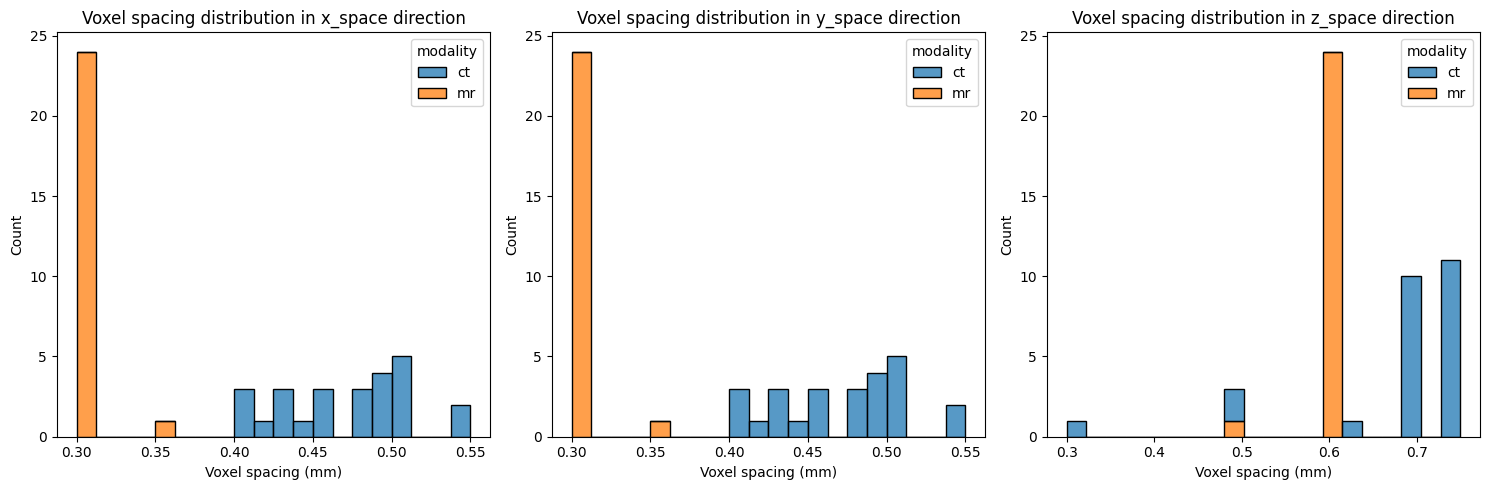

In [4]:
# Isolation of spacing informations
voxel_spacing = df[['modality', 'spacing(mm)']]
voxel_spacing.loc[:, 'x_space'] = voxel_spacing['spacing(mm)'].apply(lambda x: x[0])
voxel_spacing.loc[:, 'y_space'] = voxel_spacing['spacing(mm)'].apply(lambda x: x[1])
voxel_spacing.loc[:, 'z_space'] = voxel_spacing['spacing(mm)'].apply(lambda x: x[2])

# Plotting voxel spacing distributions
axes = ['x_space', 'y_space', 'z_space']

plt.figure(figsize=(15, 5))
for i, ax in enumerate(axes):
    plt.subplot(1, 3, i + 1)
    sns.histplot(data=voxel_spacing, x=ax, hue='modality', bins=20, multiple='stack')
    plt.title(f'Voxel spacing distribution in {ax} direction')
    plt.xlabel('Voxel spacing (mm)')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()


## FOV distribution depending on modality

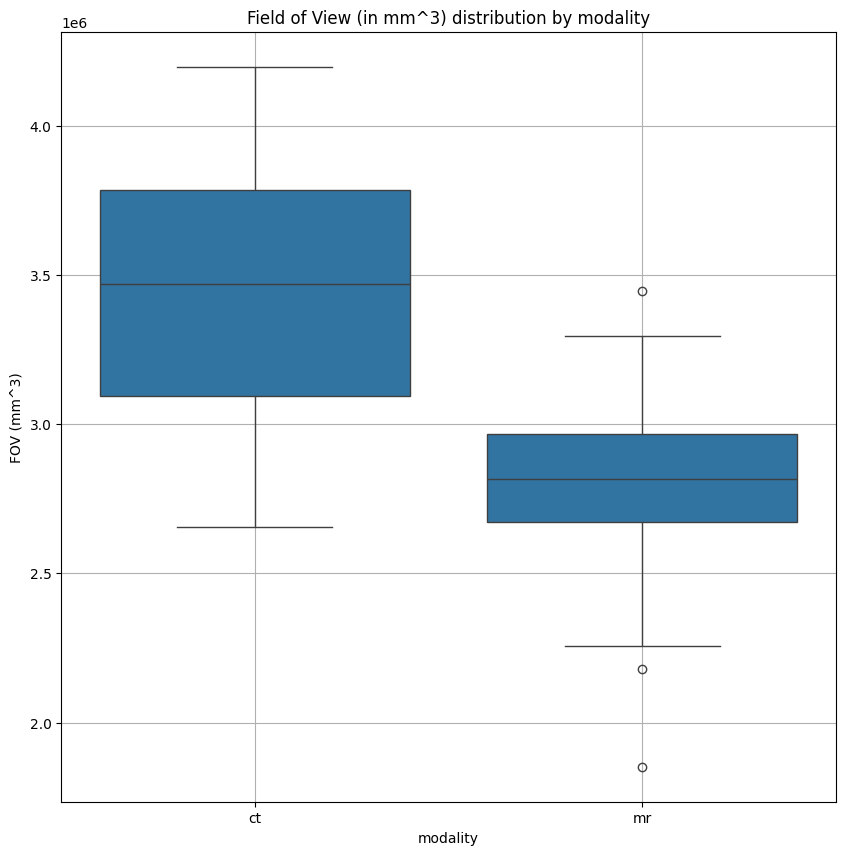

In [5]:
# Isolate FOV informations
FOV = df[['file_name', 'modality', 'FOV (mm)']].rename({'FOV (mm)': 'FOV (mm^3)'}, axis=1)
FOV['FOV (mm^3)'] = FOV['FOV (mm^3)'].apply(lambda x: np.prod(x))

plt.figure(figsize=(10, 10))
sns.boxplot(data=FOV, x='modality', y='FOV (mm^3)')
plt.title('Field of View (in mm^3) distribution by modality')
plt.grid('on')

## Labels distribution

In [6]:
import logging

logging.basicConfig(level=logging.INFO)

df['proportions'] = [[] for _ in range(len(df))]  # Initialize proportions for each label

for i, mask_path in enumerate(df['label_path']):
    logging.info(f"Processing mask {i + 1}/{len(df['label_path'])}: {mask_path}")
    if pd.isna(mask_path):
        continue
    mask = nib.load(mask_path)
    mask_data = mask.get_fdata()

    for label in range(43):
        df.loc[i, 'proportions'].append(np.sum(mask_data == label) / mask_data.size if label in mask_data else 0)


INFO:root:Processing mask 1/50: ../data/raw/labelsTr_topbrain_ct/topcow_ct_025.nii.gz
INFO:root:Processing mask 2/50: ../data/raw/labelsTr_topbrain_ct/topcow_ct_015.nii.gz
INFO:root:Processing mask 3/50: ../data/raw/labelsTr_topbrain_ct/topcow_ct_022.nii.gz
INFO:root:Processing mask 4/50: ../data/raw/labelsTr_topbrain_ct/topcow_ct_017.nii.gz
INFO:root:Processing mask 5/50: ../data/raw/labelsTr_topbrain_ct/topcow_ct_020.nii.gz
INFO:root:Processing mask 6/50: ../data/raw/labelsTr_topbrain_ct/topcow_ct_026.nii.gz
INFO:root:Processing mask 7/50: ../data/raw/labelsTr_topbrain_ct/topcow_ct_016.nii.gz
INFO:root:Processing mask 8/50: ../data/raw/labelsTr_topbrain_ct/topcow_ct_007.nii.gz
INFO:root:Processing mask 9/50: ../data/raw/labelsTr_topbrain_ct/topcow_ct_018.nii.gz
INFO:root:Processing mask 10/50: ../data/raw/labelsTr_topbrain_ct/topcow_ct_021.nii.gz
INFO:root:Processing mask 11/50: ../data/raw/labelsTr_topbrain_ct/topcow_ct_013.nii.gz
INFO:root:Processing mask 12/50: ../data/raw/labelsT

In [7]:
df.head()

,file_name,file_path,modality,shape(px),spacing(mm),FOV (mm),val_range,label_path,proportions
0,topcow_ct_025,../data/raw/imagesTr_topbrain_ct/topcow_ct_025...,ct,"[271, 340, 206]","[0.49, 0.49, 0.7]","[132.79, 166.6, 144.2]","[-1024.0, 2081.98]",../data/raw/labelsTr_topbrain_ct/topcow_ct_025...,"[0.9960489630595906, 0.0001572638513364003, 7...."
1,topcow_ct_015,../data/raw/imagesTr_topbrain_ct/topcow_ct_015...,ct,"[316, 390, 203]","[0.43, 0.43, 0.75]","[135.88, 167.7, 152.25]","[-1024.0, 2204.01]",../data/raw/labelsTr_topbrain_ct/topcow_ct_015...,"[0.9972024628943005, 0.0001526917720719554, 7...."
2,topcow_ct_022,../data/raw/imagesTr_topbrain_ct/topcow_ct_022...,ct,"[287, 351, 224]","[0.49, 0.49, 0.7]","[140.63, 171.99, 156.8]","[-1024.0, 2769.01]",../data/raw/labelsTr_topbrain_ct/topcow_ct_022...,"[0.9948171706664738, 0.00020345588725379667, 6..."
3,topcow_ct_017,../data/raw/imagesTr_topbrain_ct/topcow_ct_017...,ct,"[319, 430, 527]","[0.44, 0.44, 0.3]","[140.36, 189.2, 158.1]","[-1024.0, 2196.01]",../data/raw/labelsTr_topbrain_ct/topcow_ct_017...,"[0.996782894783257, 0.00010530015871107736, 3...."
4,topcow_ct_020,../data/raw/imagesTr_topbrain_ct/topcow_ct_020...,ct,"[290, 387, 200]","[0.46, 0.46, 0.75]","[133.4, 178.02, 150.0]","[-1024.0, 3071.0]",../data/raw/labelsTr_topbrain_ct/topcow_ct_020...,"[0.996459681012207, 0.00015423683507083668, 6...."


### Multimodal

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_3530/2426515277.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integ

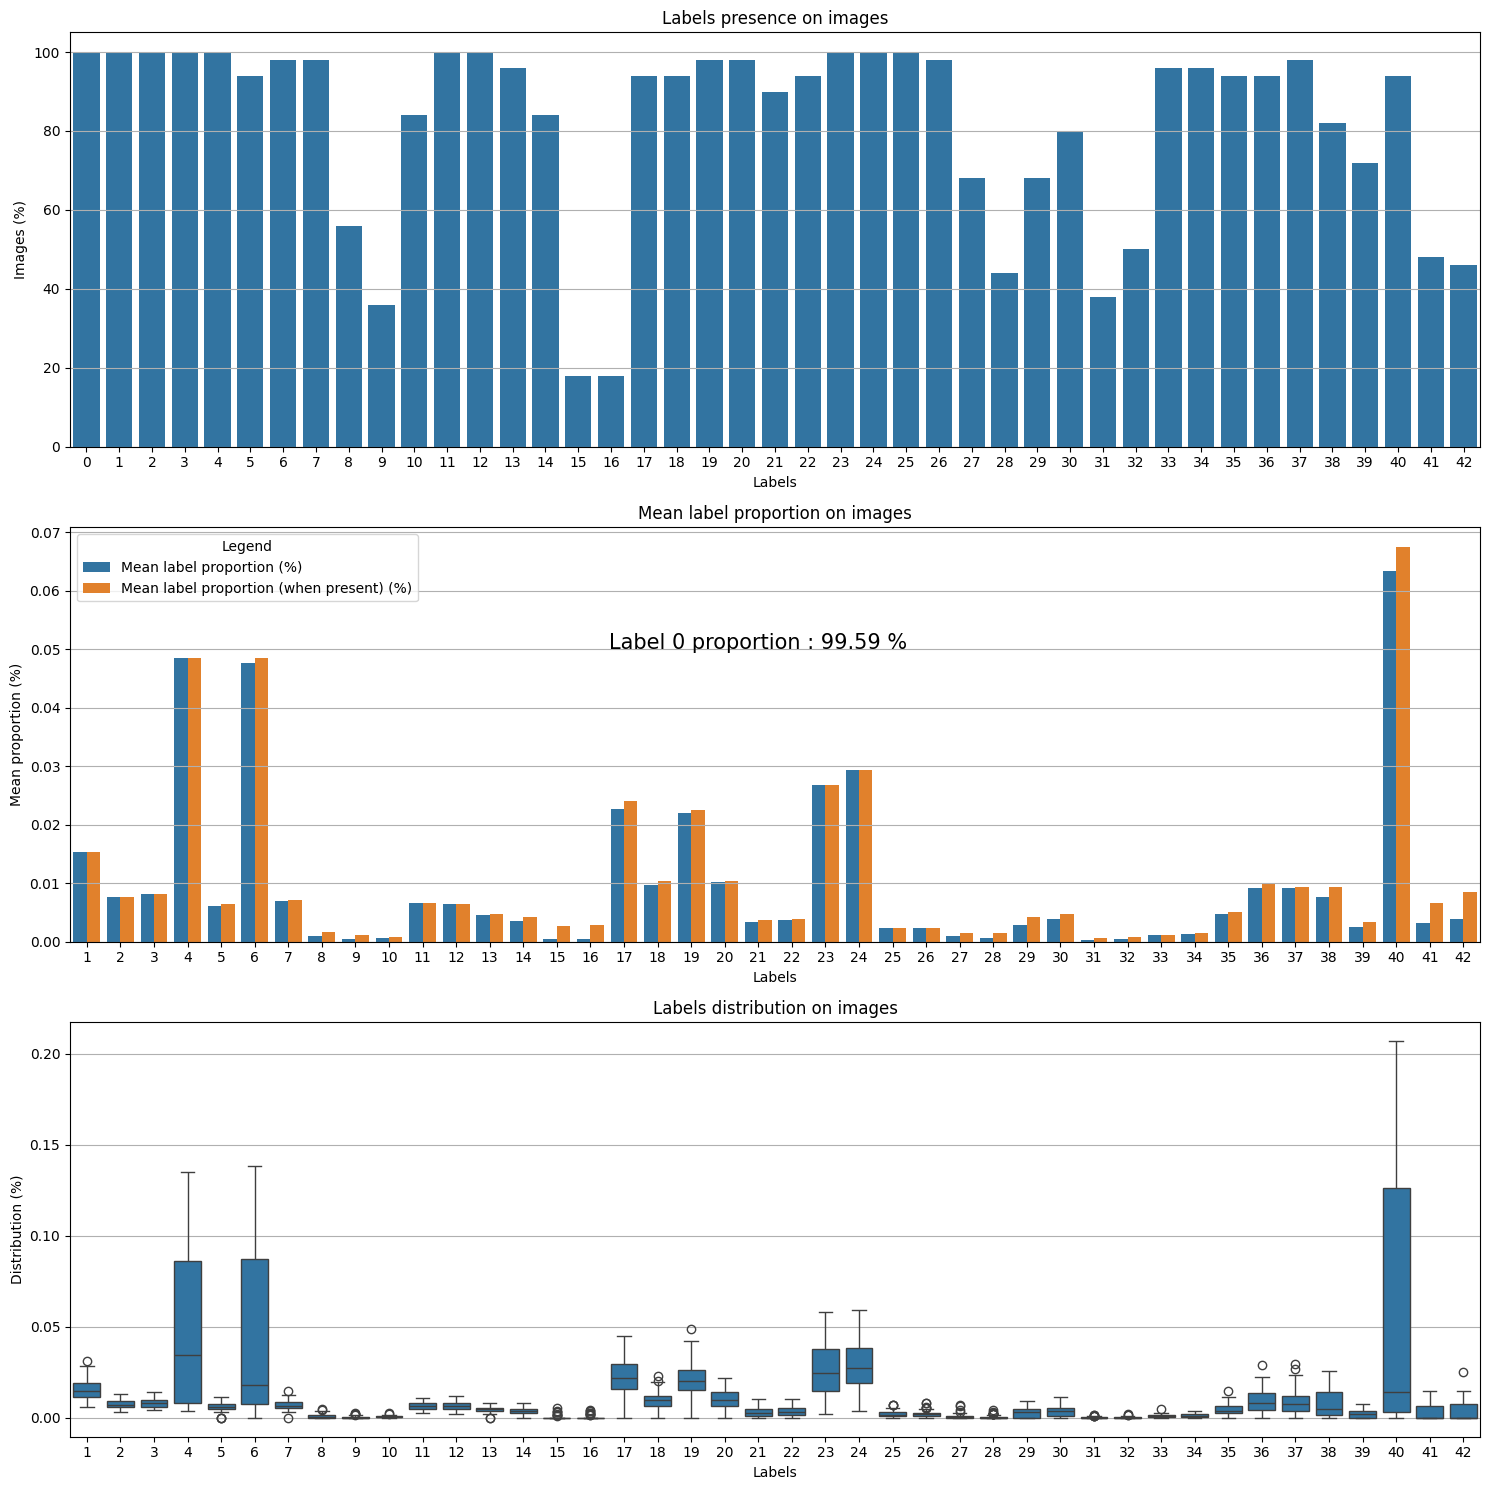

In [8]:
labels_proportions = pd.DataFrame(df['proportions'].tolist(), columns = [f'{i}' for i in range(len(df['proportions'].iloc[0]))]) # DataFrame of label proportions

# Melting the DataFrame
labels_proportions_melt = (labels_proportions.iloc[:, 1:]*100).reset_index().melt(
    id_vars=['index'],
    var_name='Label',
    value_name='Proportion'
)

# Labels presence calculation
labels_presence = labels_proportions.apply(lambda x : sum(x>0)*100/len(df), axis=0)

# Mean label proportion calculation
mean_label_proportion = pd.DataFrame({
    'Label' : list(range(1, 43)) + list(range(1, 43)),
    'Mean label proportion (%)' : (labels_proportions.mean(axis=0)*100).tolist()[1:] + (labels_proportions[labels_proportions > 0].mean(axis=0)*100).tolist()[1:],
    'Legend' : ["Mean label proportion (%)" for i in range(len(labels_proportions.columns)-1)] + ["Mean label proportion (when present) (%)" for i in range(len(labels_proportions.columns)-1)]
})

plt.figure(figsize=(15, 15))

plt.subplot(3, 1, 1)
sns.barplot(x=range(43), y=labels_presence)
plt.title('Labels presence on images')
plt.xlabel('Labels')
plt.ylabel('Images (%)')
plt.grid(axis='y')

plt.subplot(3, 1, 2)
sns.barplot(x='Label', y='Mean label proportion (%)', hue='Legend', data=mean_label_proportion)
plt.text(20, 0.05, f"Label 0 proportion : {labels_proportions.mean(axis=0)[0]*100:.2f} %", fontsize=15, color='black', horizontalalignment='center')
plt.title('Mean label proportion on images')
plt.xlabel('Labels')
plt.ylabel('Mean proportion (%)')
plt.grid(axis='y')

plt.subplot(3, 1, 3)
sns.boxplot(x='Label', y='Proportion', data=labels_proportions_melt)
plt.title('Labels distribution on images')
plt.xlabel('Labels')
plt.ylabel('Distribution (%)')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

### Depending on modality

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

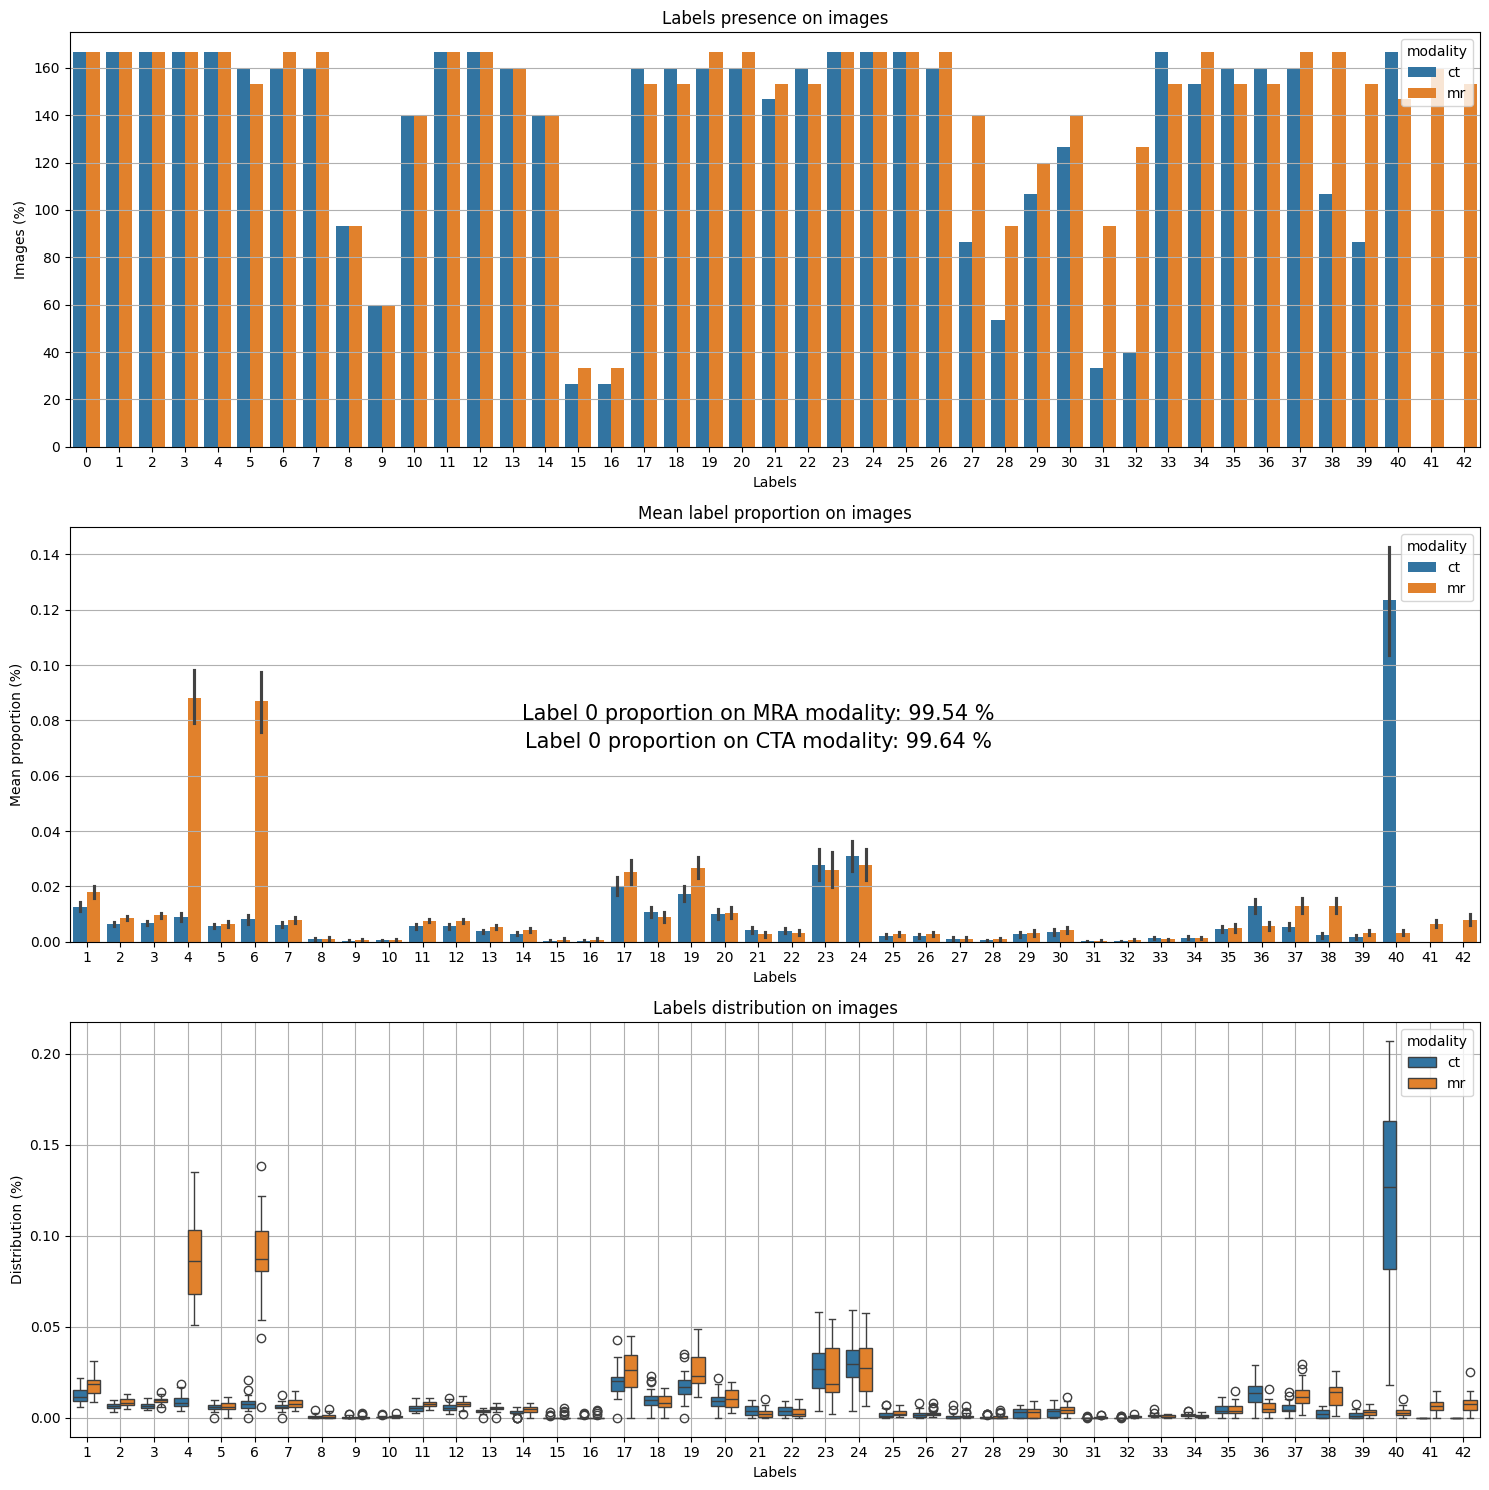

In [10]:
proportions = pd.DataFrame(df['proportions'].tolist(), columns = [i for i in range(len(df['proportions'].iloc[0]))], index=df.index)
df_proportions = df[['modality']].join(proportions)
df_proportions_melt = (df_proportions.drop(columns=[0])).melt(
    id_vars=['modality'],
    var_name='Label',
    value_name='Proportion'
)
df_proportions_melt['Proportion'] = df_proportions_melt['Proportion']*100

# Labels presence calculation
labels_presence = df_proportions.apply(lambda x: x.apply(lambda y: 1 if y else 0) if x.name != 'modality' else x)
labels_presence = labels_presence.groupby(['modality']).sum().reset_index().melt(
    id_vars=['modality'],
    var_name='Label',
    value_name='Presence'
)
labels_presence['Presence'] = labels_presence['Presence']*100/15

plt.figure(figsize=(15, 15))

plt.subplot(3, 1, 1)
sns.barplot(x='Label', y='Presence', hue='modality', data=labels_presence)
plt.title('Labels presence on images')
plt.xlabel('Labels')
plt.ylabel('Images (%)')
plt.grid(axis='y')

plt.subplot(3, 1, 2)
sns.barplot(x='Label', y='Proportion', hue='modality', data=df_proportions_melt)
plt.text(20, 0.08, f"Label 0 proportion on MRA modality: {df_proportions.loc[df_proportions['modality'] == 'mr', 0].mean()*100:.2f} %", fontsize=15, color='black', horizontalalignment='center')
plt.text(20, 0.07, f"Label 0 proportion on CTA modality: {df_proportions.loc[df_proportions['modality'] == 'ct', 0].mean()*100:.2f} %", fontsize=15, color='black', horizontalalignment='center')
plt.title('Mean label proportion on images')
plt.xlabel('Labels')
plt.ylabel('Mean proportion (%)')
plt.grid(axis='y')

plt.subplot(3, 1, 3)
sns.boxplot(x='Label', y='Proportion', data=df_proportions_melt, hue='modality')
plt.title('Labels distribution on images')
plt.xlabel('Labels')
plt.ylabel('Distribution (%)')
plt.grid()

plt.tight_layout()
plt.show()